In [86]:

import importlib
import modules
from collections import Counter
import numpy as np
import powerlaw
import importlib
import modules
from modules import calculate_flow_nasch
from modules import nasch_step
from modules import initial_state_nasch
from modules import run_model_stochastic

import cellpylib as cpl

from modules import triangulize_evolution
from modules import find_jams
import matplotlib.pyplot as plt

from modules import run_model_stochastic
import random
import sys

importlib.reload(modules)


<module 'modules' from '/Users/carokluin/Documents/CSM/ComplexSystems/Project_complexsystems/CSS-Group1/modules.py'>

# Traffic density heatmap
## We could plot the traffic density over time, see if it approaches the critical density like we would expect for Self-Organized Criticality

In [45]:
def plot_traffic_density(evolution):
    """
    Plot the traffic density heatmap for a given density evolution.

    Parameters:
    - evolution (numpy.ndarray): Traffic density evolution over time and space.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(evolution, cmap='YlOrRd', aspect='auto', origin='lower')
    plt.colorbar(label='Traffic Density')
    plt.xlabel('Position')
    plt.ylabel('Time Step')
    plt.title('Traffic Density Evolution')

    plt.show()


# Functions that checks if powerlaw distribution can be fitted

In [92]:
#set up function to fit power law distribution
def analyze_powerlaw_distribution(data):
    """
    Function that analysis the distribution of given data with the powerlaw package.
    Makes use of the Kolmogorov-Smirnov test which returns R-log likelihood (ks_stat) and p-value (ks_p_value). 
    p-value/ks_p_value > 0.05 means that the data is likely to be drawn from the same distribution.
    R/ks_stat <0  means the data is drawn from a exponential distribution
    R/ks_stat >0 means the data is drawn from a power law distribution 


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    distr1 = "power_law"
    distr2 = "exponential"
    ks_stat, ks_p_value = fit.distribution_compare(distr1, distr2, normalized_ratio=True)
    exponent = fit.power_law.alpha
    

    # Analyze the fit and return the result
    if ks_stat > 0:
        # R log likelihood was positive, so data prefers power-law distribution
        result = f"Data prefers {distr1} over {distr2} (p-value: {ks_p_value:.4f})"

    else:
        # R log likelihood was negative, so data prefers exponential distribution
        result = f"Data prefers {distr2} over {distr1} (p-value: {ks_p_value:.4f})"

    return result, exponent



In [ ]:

def plot_model_evolution(evolution, v_max, title="NaSch Model Evolution", cmap="Greys"):
    """
    Function to plot the evolution of the NaSch model.

    Parameters:
    - evolution (list): List containing the evolution of the model for each timestep.
    - v_max (int): Maximum speed of vehicles.
    - title (str): Title of the plot.
    - cmap (str): Colormap for the heatmap.

    Returns:
    - None (displays the plot).
    """
    density_evolution = np.array([[np.sum([cell[0] for cell in state]) / len(state) for state in evolution]])

    plt.figure(figsize=(10, 6))
    plt.imshow(density_evolution, cmap=cmap, origin="lower", aspect="auto", extent=[0, len(evolution[0]), 0, len(evolution)])
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Cell Index")
    plt.colorbar(label="Density")
    plt.yticks(np.arange(0, len(evolution) + 1, 5))
    plt.xticks(np.arange(0, len(evolution[0]) + 1, 5))
    plt.show()



# Code to capture the density over time 

In [9]:
def density_evolution_nasch (evolution):
    """
    Function to calculate the density evolution of the NaSch model. The density is defined as the
    amount of cars in total. This is calculated by summing the total amount of cars.
    Input: 
    - evolution (list): List containing the evolution of the model for each timestep.
    Output:
    - density_evolution (list): List containing the density evolution of the model for each timestep.
    """
    location_evolution = [[x[0] for x in line] for line in evolution]
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]
    return density_evolution



# Non dynamic NaSch checking for power law and "power law plots" for different values of vmax and p_slowdown


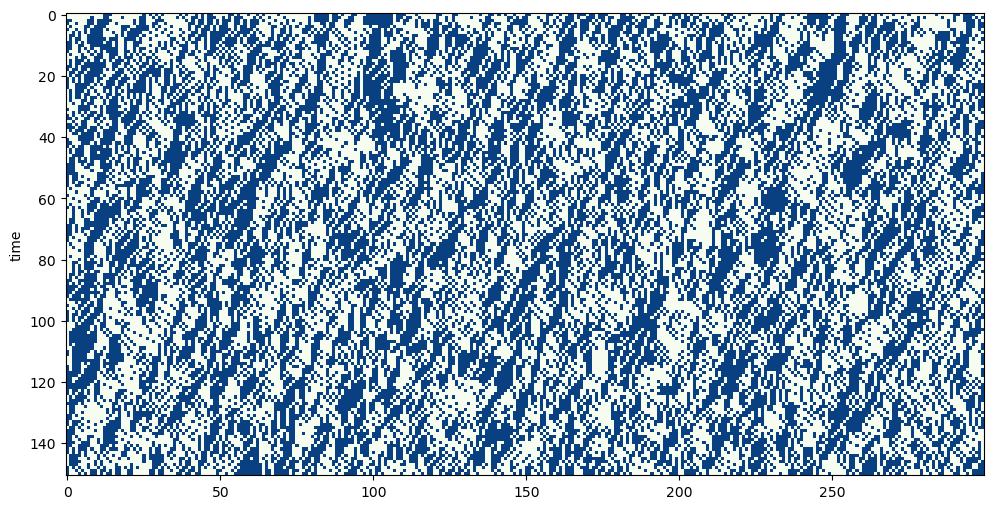

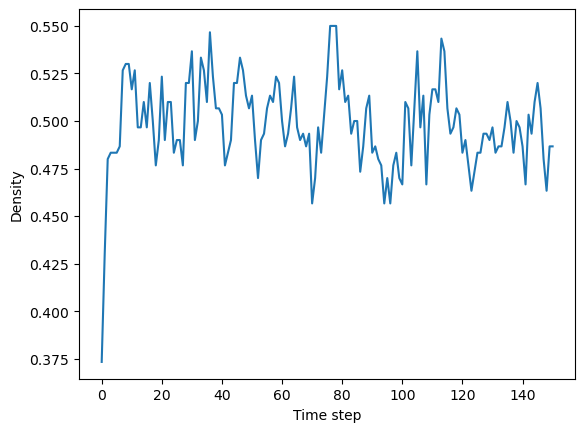

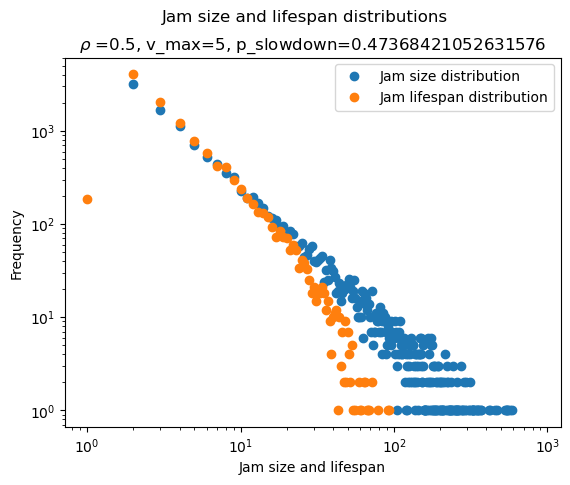

Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0000)
1.6907868951716671
Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0000)
1.6907868951716671


In [97]:
p = 0.2 #0.13793103448275862
L = 300
T = int(L/2)
n = 10

# NaSch parameters
p_slowdown = 0.47368421052631576
v_max = 5

# Dynamic parameters
neighbourhood_size = 30
entry_chance = 0.2
exit_chance = 0.2

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)

# Visualize the evolution
evolution = evolutions[0]

location_evolution = [[x[0] for x in line] for line in evolution]
speed_evolution = [[x[1] for x in line] for line in evolution]

#flow = calculate_flow_nasch(evolution)
#print(f"Flow: {flow}")

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(location_evolution, colormap='GnBu')

density_test = density_evolution_nasch(evolution)
plt.plot(density_test)
plt.ylabel('Density')
plt.xlabel('Time step')
plt.show()

plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o')
plt.loglog(range(1, int(max(lifespan_counter.keys()))), [lifespan_counter[i] for i in range(1, int(max(lifespan_counter.keys())))], 'o')
plt.legend(['Jam size distribution', 'Jam lifespan distribution'])
plt.title('$\\rho$ =0.5, v_max=5, p_slowdown=0.47368421052631576')
plt.xlabel('Jam size and lifespan')
plt.ylabel('Frequency')
plt.suptitle('Jam size and lifespan distributions')
plt.show()

result, exponent = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)
result_lifespan_test = analyze_powerlaw_distribution(list(lifespan_counter.elements()))
print(result) #print result of power law test
print(exponent)

In [214]:
p_value = np.linspace(0.1, 0.9, 9)

for p in p_value: 
    current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

    evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                        dynamic_model=False, neighbourhood_size=neighbourhood_size, 
                        entry_chance=entry_chance, exit_chance=exit_chance)

    lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                        return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                        entry_chance=entry_chance, exit_chance=exit_chance)

    result_jam_test = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
    print ("for initial density:", p) 
    print(result_jam_test) #print result of power law test



Calculating best minimal value for power law fit
for initial density: 0.1
('Data prefers power_law over exponential (p-value: 0.0641)', 2.374227430335104)
Calculating best minimal value for power law fit
for initial density: 0.2
('Data prefers power_law over exponential (p-value: 0.0000)', 2.0952555485066355)
Calculating best minimal value for power law fit
for initial density: 0.30000000000000004
('Data prefers power_law over exponential (p-value: 0.0151)', 2.4488601151154317)
Calculating best minimal value for power law fit
for initial density: 0.4
('Data prefers power_law over exponential (p-value: 0.0000)', 1.8142578220983685)
Calculating best minimal value for power law fit
for initial density: 0.5
('Data prefers power_law over exponential (p-value: 0.0000)', 1.7544691052832637)
Calculating best minimal value for power law fit
for initial density: 0.6
('Data prefers power_law over exponential (p-value: 0.0000)', 1.6837419791108323)
Calculating best minimal value for power law fit


# Example NaSch without dynamics

In [307]:
import sys
sys.setrecursionlimit(10000)

#Critical densities for p_slowdown and vmax
#0.4482758620689655,3,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2413793103448276, 0.22068965517241382, 0.2, 0.2]

p = 0.22068965517241382
L = 300
T = int(L/2)
n = 100

# NaSch parameters
p_slowdown = 0.4482758620689655
v_max = 3

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=False, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)


def power(x,b):
    return x**(-b)


file = open('Results/loglog_jam_nondynamic_critical.txt', 'wb')
pickle.dump(loglog_jam_nondynamic_critical, file)
file.close()

Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0000)
1.8848979637165932


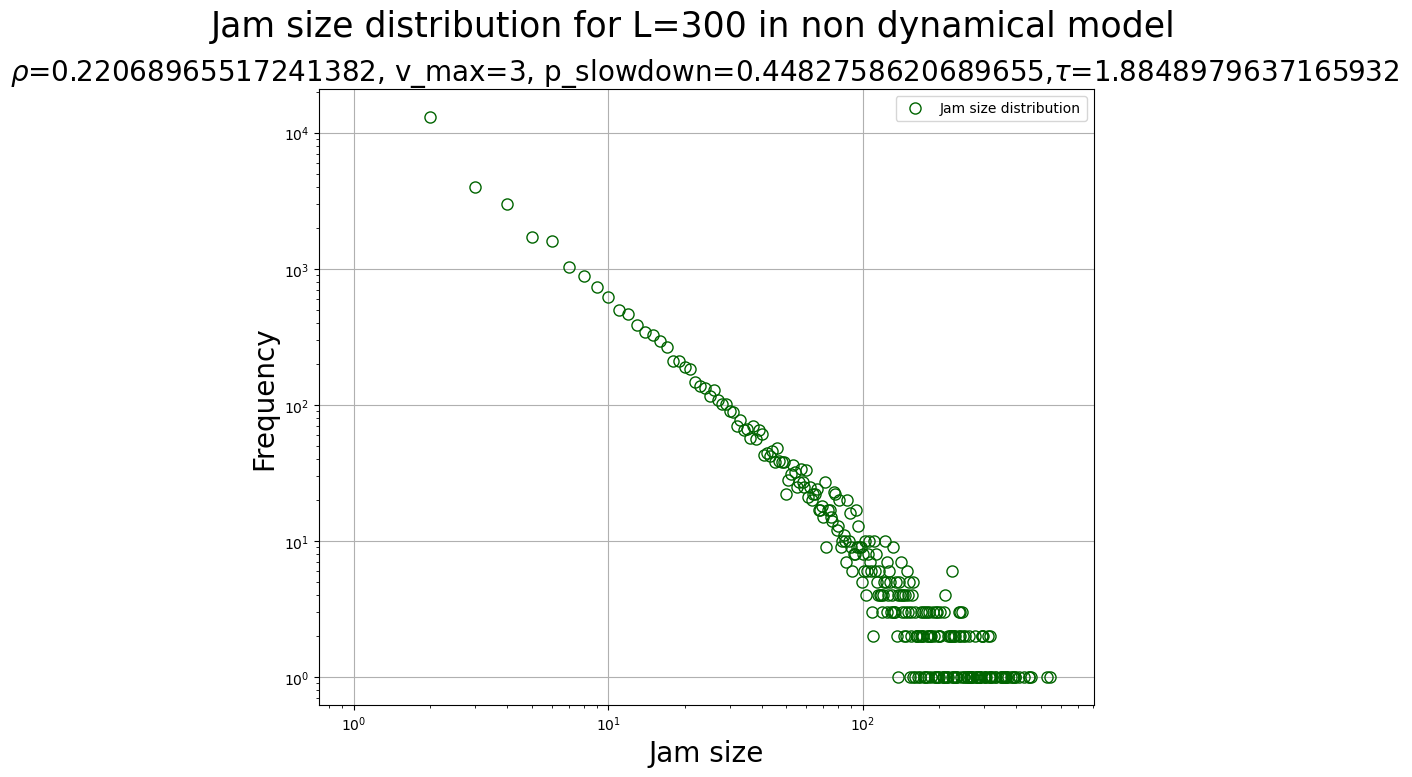

In [308]:
result, exponent = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)
 

plt.figure(figsize=(10,8))
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='#356058', markersize=8)

#line to plot the critical exponent line in the plot 
#plt.loglog(range(1, int(max(jam_size_counter.keys()))), power(range(1, int(max(jam_size_counter.keys()))), exponent), '--')
plt.legend(['Jam size distribution'])
plt.grid()
plt.title(f'$\\rho$={p}, v_max={v_max}, p_slowdown={p_slowdown},$\\tau$={exponent} ', fontsize=10)
plt.xlabel('Jam size', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.suptitle(f'Jam size distribution for L={L} in non dynamical model', fontsize=25)
plt.show()

# Example NaSch With Dynamics 

In [296]:
p = 0.22068965517241382
L = 300
T = int(L/2)
n = 100

# NaSch parameters
p_slowdown = 0.4482758620689655
v_max = 3

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)


def power(x,b):
    return x**(-b)

file = open('Results/loglog_jam_dynamic_critical.txt', 'wb')
pickle.dump(loglog_jam_nondynamic_critical, file)
file.close()

Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0000)
1.7640798526637858
Calculating best minimal value for power law fit
('Data prefers power_law over exponential (p-value: 0.0000)', 1.9655531888953481)
Counter({2: 35728, 3: 16264, 4: 9591, 5: 6383, 6: 4665, 7: 3442, 8: 2750, 9: 2189, 10: 1784, 11: 1536, 12: 1332, 13: 1094, 14: 1038, 15: 849, 16: 739, 17: 638, 18: 577, 19: 534, 20: 481, 21: 465, 22: 402, 23: 350, 24: 335, 25: 308, 26: 289, 27: 242, 28: 232, 29: 209, 31: 198, 33: 178, 30: 169, 32: 163, 34: 135, 36: 129, 35: 117, 37: 113, 38: 108, 41: 103, 39: 87, 40: 83, 43: 76, 42: 73, 47: 66, 46: 62, 48: 58, 45: 56, 49: 54, 51: 54, 44: 53, 50: 45, 52: 44, 56: 40, 55: 40, 54: 39, 53: 37, 58: 35, 57: 32, 60: 28, 59: 26, 67: 23, 62: 21, 61: 21, 70: 20, 68: 19, 64: 19, 63: 19, 69: 18, 65: 16, 66: 15, 72: 14, 74: 14, 1: 14, 71: 13, 79: 13, 78: 11, 77: 10, 73: 10, 76: 9, 81: 8, 80: 8, 75: 8, 87: 7, 83: 7, 94: 7, 85: 6, 86: 6, 88: 5, 82: 

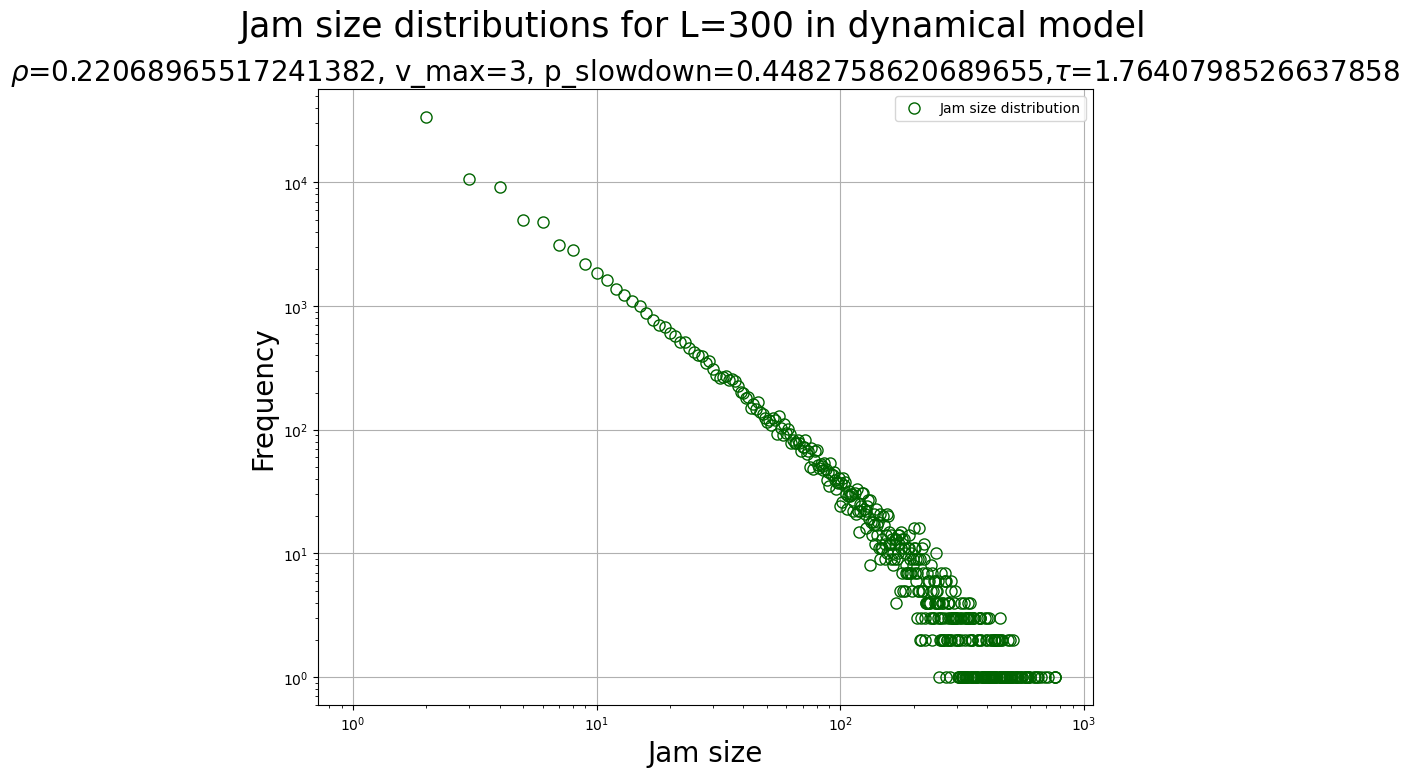

In [297]:
result, exponent = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)
esult_lifespan_test = analyze_powerlaw_distribution(list(lifespan_counter.elements()))
print(result_lifespan_test) #print result of power law test
print(lifespan_counter)   

plt.figure(figsize=(10,8))
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='#356058', markersize=8)
#plt.loglog(range(1, int(max(lifespan_counter.keys()))), [lifespan_counter[i] for i in range(1, int(max(lifespan_counter.keys())))], 'o', color='black', markersize=8)
#line to plot the critical exponent line in the plot 
#plt.loglog(range(1, int(max(jam_size_counter.keys()))), power(range(1, int(max(jam_size_counter.keys()))), exponent), '--')
plt.legend(['Jam size distribution'])
plt.grid()
plt.title(f'$\\rho$={p}, v_max={v_max}, p_slowdown={p_slowdown},$\\tau$={exponent}', fontsize=10)
plt.xlabel('Jam size', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.suptitle(f'Jam size distributions for L={L} in dynamical model', fontsize=25)
plt.show()

# Example CA (p_slowdown=0, vmax=1)


In [301]:
import sys
sys.setrecursionlimit(10000)

p = 0.22068965517241382
L = 300
T = int(L/2)
n = 10

# NaSch parameters
p_slowdown = 0 
v_max = 1 

# Dynamic parameters
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01


current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=False, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)


def power(x,b):
    return x**(-b)

file = open('Results/loglog_jam_CA_critical.txt', 'wb')
pickle.dump(loglog_jam_CA_critical, file)
file.close()


Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.1190)
2.755098892295492


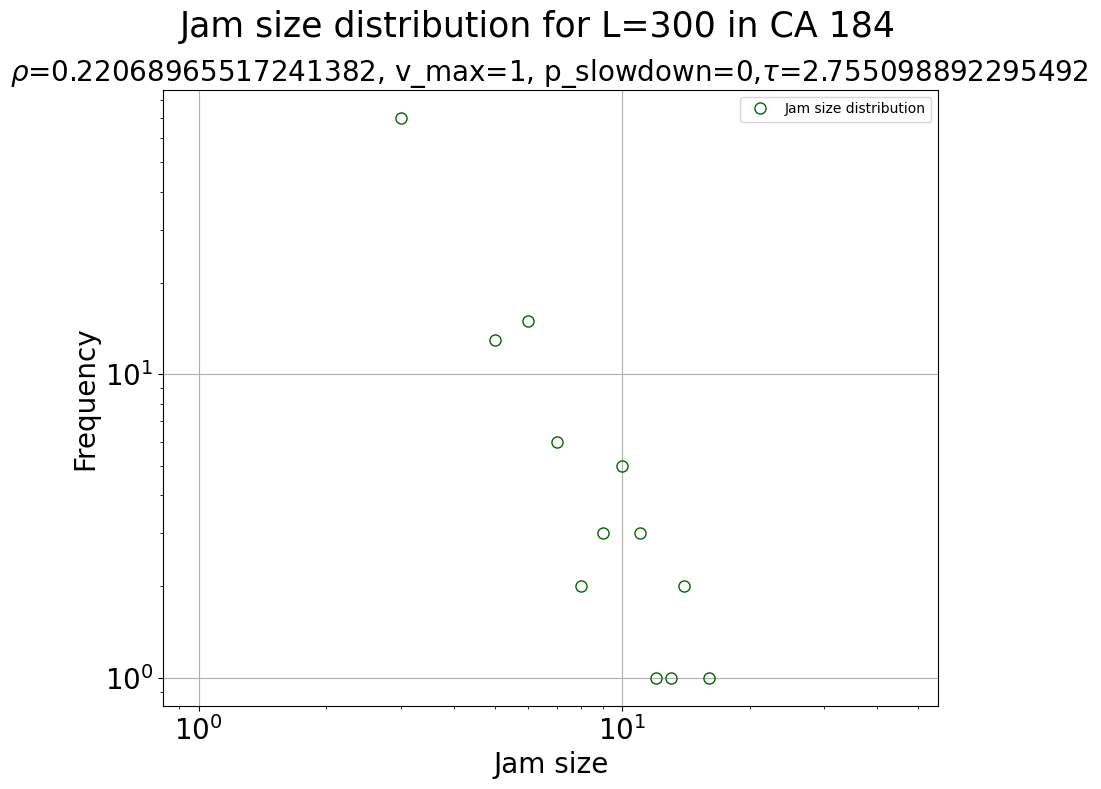

In [302]:
#check for powerlaw and make loglog plot for visualisation
result, exponent = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)

plt.figure(figsize=(10,8))
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='#356058', markersize=8)

#line to plot the critical exponent line in the plot 
#plt.loglog(range(1, int(max(jam_size_counter.keys()))), power(range(1, int(max(jam_size_counter.keys()))), exponent), '--')
plt.legend(['Jam size distribution'])
plt.grid()
plt.title(f'$\\rho$={p}, v_max={v_max}, p_slowdown={p_slowdown},$\\tau$={exponent} ', fontsize=10)
plt.xlabel('Jam size', fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.suptitle(f'Jam size distribution for L={L} in CA 184', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Analyze powerlaw exponent of the NaSch traffic flow

In [161]:
#p = 0.2 #0.13793103448275862
L = 300
T = int(L/2)
n = 100

# NaSch parameters
p_slowdown = 0 #0.3157894736842105
v_max = 1 #3

# Dynamic parameters
neighbourhood_size = 50
entry_chance = 0.1
exit_chance = 0.1


p_value = np.linspace(0.1, 0.9, 9)

for p in p_value: 
    current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

    evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                        dynamic_model=False, neighbourhood_size=neighbourhood_size, 
                        entry_chance=entry_chance, exit_chance=exit_chance)

    lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                        return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                        entry_chance=entry_chance, exit_chance=exit_chance)

    result_jam_test = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
    result_jam_test = analyze_powerlaw_distribution(list(lifespan_counter.elements()))
    print ("for initial density:", p) 
    print(result_jam_test) #print result of power law test
    print(result_lifespan_test) 

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
for initial density: 0.1
('Data prefers exponential over power_law (p-value: 0.1363)', 7.019224152744982)
('Data prefers power_law over exponential (p-value: 0.0000)', 1.9655531888953481)
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
for initial density: 0.2
('Data prefers power_law over exponential (p-value: 0.9349)', 4.343480774475939)
('Data prefers power_law over exponential (p-value: 0.0000)', 1.9655531888953481)
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
for initial density: 0.30000000000000004
('Data prefers power_law over exponential (p-value: 0.7290)', 2.851103282189878)
('Data prefers power_law over exponential (p-value: 0.0000)', 1.9655531888953481)
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
for initial density: 0.4
('D

# Show relationship between critical exponent and initial density

In [313]:

import sys
import pickle
sys.setrecursionlimit(50000)


# A power-law distribution for a given initial density
def analyze_critical_exponent_for_density(p, L, T, n_repetitions, v_max, p_slowdown, triangular, dynamic_model, neighbourhood_size, entry_chance, exit_chance):
    """Function that saves the critical exponent for a initial density."""

    # Nasch model
    lifespan_counter, jam_counter = run_model_stochastic(p, L, T, n_repetitions, v_max, p_slowdown, triangular, return_evolutions=False, dynamic_model=dynamic_model, neighbourhood_size=neighbourhood_size, entry_chance=entry_chance, exit_chance=exit_chance)
    
    # Previous defined analyze_powerlaw_distribution function 
    result, exponent = analyze_powerlaw_distribution(list(jam_counter.elements()))
    
    return p, exponent

# Parameters
L = 300
T = int(L/2)
n_repetitions = 50
v_max = 3
p_slowdown = 0.2
triangular = False
dynamic_model = True
neighbourhood_size = 10
entry_chance = 0.01
exit_chance = 0.01

# Initial Densities 
initial_densities = np.linspace(0.1, 0.85, 100)

# Collect Results
results = [analyze_critical_exponent_for_density(p, L, T, n_repetitions, v_max, p_slowdown, triangular, dynamic_model, neighbourhood_size, entry_chance, exit_chance) for p in initial_densities]

# Unpack Results
densities, exponents = zip(*results)

# Visualize Results
# Perform linear regression
fit_params = np.polyfit(densities, exponents, 1)
fit_line = np.polyval(fit_params, densities)

file = open('Results/densities_density_dynamic_pslow02.txt', 'wb')
pickle.dump(results, file)
file.close()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

In [311]:
file = open('Results/densities_density_dynamic_pslow08.txt', 'wb')
pickle.dump(results, file)
file.close()

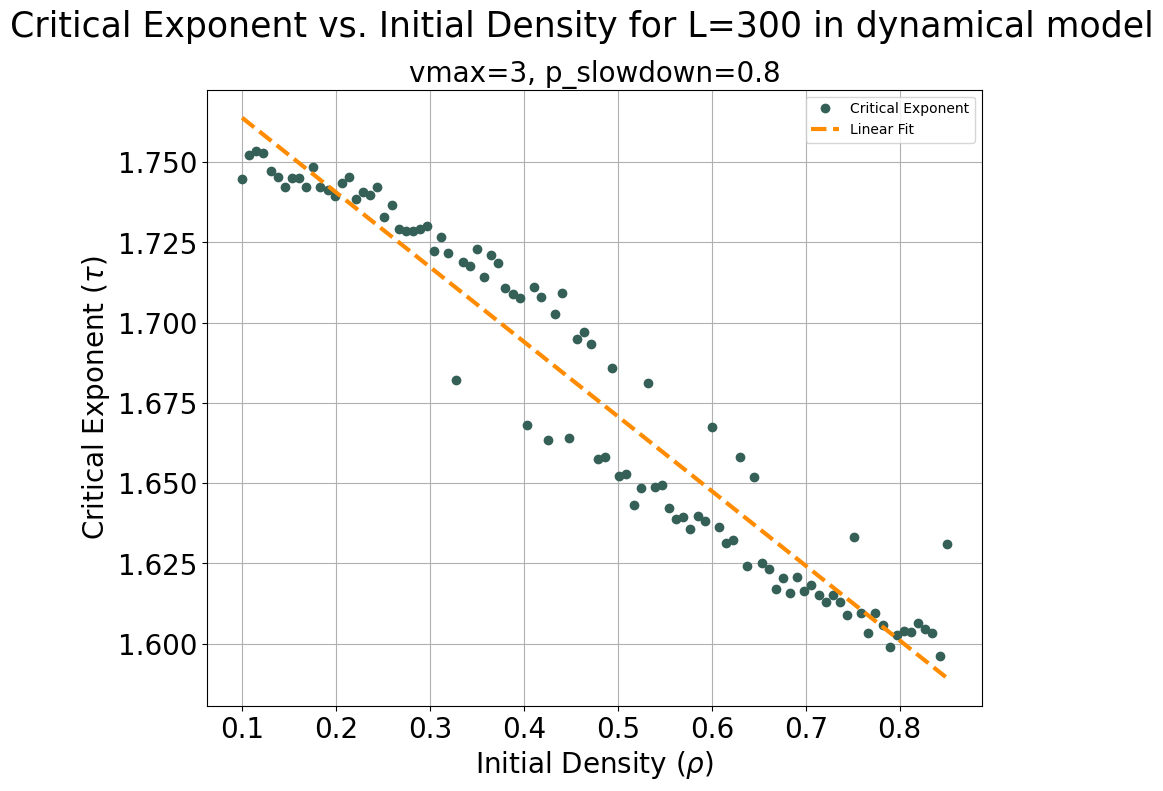

In [312]:
# Visualize Results
file = open('Results/densities_density_dynamic_pslow08.txt', 'rb')
results = pickle.load(file)

# Perform linear regression
fit_params = np.polyfit(densities, exponents, 1)
fit_line = np.polyval(fit_params, densities)

plt.figure(figsize=(10,8))
plt.grid()
plt.plot(densities, exponents, 'o', color='#356058',linewidth=3,label='Critical Exponent')
plt.plot(densities, fit_line, '--', color='darkorange', linewidth=3, label='Linear Fit')
plt.xlabel('Initial Density ($\\rho$)', fontsize=20)
plt.ylabel('Critical Exponent ($\\tau$)', fontsize=20)
plt.title(f'vmax={v_max}, p_slowdown={p_slowdown}', fontsize=20)
plt.suptitle(f'Critical Exponent vs. Initial Density for L={L} in dynamical model', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.show()
